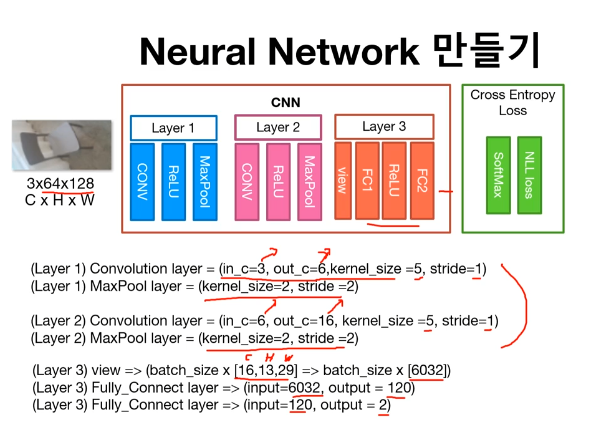


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [25]:
trans = transforms.Compose([
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder('d:\data\python\cnn_image\Train_data', transform = trans)

In [26]:
data_loader = DataLoader (dataset = train_data, batch_size = 8, shuffle = True, num_workers=2)

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(16*13*29, 120),
            nn.ReLU(),
            nn.Linear(120,3)
        )
    # 64*128 크기의 Tensor가 layer2까지 지나고 나면 [1,16,13,29]인 Tensor가 됨
    # fc를 두번거치도록 하면서, 중간 out 크기가 120이 되도록 했고, out 종류를 3개로 했음
    
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = out.view(out.shape[0],-1)
        # print(out.shape)
        out = self.layer3(out)
        return out

In [37]:
# testing: 위 forward 함수에서 각 Step마다 print를 진행하여 layer modeling이 잘 되었는지 확인한다.
net = CNN().to(device)
test_input = (torch.Tensor(3,3,64,128)).to(device)
test_out = net(test_input)

In [50]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss().to(device)

In [51]:
total_batch = len(data_loader)

epochs = 20
for epoch in range(epochs):
    avg_cost = 0
    for num, data in enumerate(data_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net (imgs)
        loss = loss_func(out, labels)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
    print('[Epoch:{}] cost = {}'.format(epoch + 1, avg_cost))
print('Learning Finished!')

[Epoch:1] cost = 0.25855574011802673
[Epoch:2] cost = 0.3731152415275574
[Epoch:3] cost = 0.26914459466934204
[Epoch:4] cost = 0.2396659404039383
[Epoch:5] cost = 0.22093085944652557
[Epoch:6] cost = 0.21036408841609955
[Epoch:7] cost = 0.1887492537498474
[Epoch:8] cost = 0.178547665476799
[Epoch:9] cost = 0.193442702293396
[Epoch:10] cost = 0.16615472733974457
[Epoch:11] cost = 0.1561070680618286
[Epoch:12] cost = 0.1457410603761673
[Epoch:13] cost = 0.1491653025150299
[Epoch:14] cost = 0.14707869291305542
[Epoch:15] cost = 0.14096930623054504
[Epoch:16] cost = 0.14039285480976105
[Epoch:17] cost = 0.1577194333076477
[Epoch:18] cost = 0.14764143526554108
[Epoch:19] cost = 0.10715635865926743
[Epoch:20] cost = 0.1040942594408989
Learning Finished!


In [52]:
# 학습된 상태를 model로 저장
torch.save(net.state_dict(),'d:\data\python\cnn_image\Image_Train_Model.pth')

In [53]:
# 학습된 모델을 불러서 만드는 과정
new_net = CNN().to(device)
new_net.load_state_dict(torch.load('d:\data\python\cnn_image\Image_Train_Model.pth'))

<All keys matched successfully>

In [54]:
# 불러온 모델이 기존것과 같은지 확인하는 과정
print(net.layer1[0])
print(new_net.layer1[0])

print(net.layer1[0].weight[0][0][0])
print(new_net.layer1[0].weight[0][0][0])

net.layer1[0].weight[0] == new_net.layer1[0].weight[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
tensor([-0.0210,  0.1197, -0.0066,  0.1150, -0.0108], grad_fn=<SelectBackward>)
tensor([-0.0210,  0.1197, -0.0066,  0.1150, -0.0108], grad_fn=<SelectBackward>)


tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]])

학습된 결과를 실제 Test해보는 과정

In [55]:
# Test Data 불러오기
trans = transforms.Compose([
    transforms.Resize((64,128)),
    transforms.ToTensor()
])

test_data = torchvision.datasets.ImageFolder('d:\data\python\cnn_image\Test_data', transform = trans)

In [56]:
test_set = DataLoader(dataset = test_data, batch_size=len(test_data))

In [57]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        print(prediction)
        
        correct_prediction = torch.argmax(prediction, 1) == label
        
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

tensor([[ 1.5293,  0.3990, -3.2225],
        [ 1.7904,  0.1020, -3.1763],
        [ 2.2626,  0.1422, -3.7921],
        [ 2.3169,  0.1045, -3.8307],
        [-3.0649,  1.1687,  1.0919],
        [-2.9495,  0.9424,  1.1932],
        [-4.9649,  2.0060,  2.2251],
        [-2.9080,  1.5705,  0.4231],
        [-4.5102,  0.1319,  3.7549],
        [-3.1244,  0.8494,  1.5361],
        [-4.6865,  2.0148,  1.9112],
        [-5.0368,  1.5499,  2.7700]])
Accuracy: 0.75
